# Notes on Python

## Python

#### For firedrake

Create a file with the following content and save in bin of firedrake in order to start python in the corresponding env.

```bash
#!/usr/bin/env bash

SCRIPT_DIR=$( cd -- "$( dirname -- "${BASH_SOURCE[0]}" )" &> /dev/null && pwd )
FIRDRAKE_BASENAME=$( basename $( dirname $SCRIPT_DIR ) )  # firedrake-comple
MY_SPACK_DIR=$( dirname $( dirname $SCRIPT_DIR ) )           # /.../firedrake-env
MY_SPACK_LOG=$(spack env status)

if [ "`basename \"$VIRTUAL_ENV\"`" != "$FIRDRAKE_BASENAME" ]; then
        if [ "$VIRTURE_ENV" != "" ]; then
                deactivate
        fi
        if `echo "$MY_SPACK_LOG" | grep -v "$MY_SPACK_DIR" > /dev/null 2>&1`; then
                if `echo "$MY_SPACK_LOG" | grep -v "No" > /dev/null 2>&1`; then
                        spack env deactivate
                fi
                spack env activate $MY_SPACK_DIR -p
                unset PYTHON_PATH
        fi
        . $SCRIPT_DIR/activate
fi

export MPIR_CVAR_ENABLE_GPU=0
export OMP_NUM_THREADS=1
# pass all the paramter to pthon
$SCRIPT_DIR/python $@
```

### Load your package
Some times we would like to import files from other folds

1. First add the path to system path by
2. Import the package

In [3]:
import os
import sys 
mypath = '..'  # the path of your path file (my file is utils/Tools.py)
sys.path.append(mypath) # ma

from utils.surface import SubManifoldBC, grad_surf

### Reload your packge

In [2]:
import fdtools
import importlib

fdtools = importlib.reload(fdtools)

### set environment

In [5]:
import os

os.environ['ABC'] = '3'

### Arrays

Inverse an array

In [12]:
a = [1, 2, 3]
b = a[::-1]
print(a)
print(b)

[1, 2, 3]
[3, 2, 1]


### PrograssBar

In [7]:
from tqdm import tqdm
from time import sleep

pbar = tqdm(["a", "b", "c", "d"])
for char in pbar:
    sleep(0.25)
    pbar.set_description("Processing %s" % char)

Processing d: 100%|██████████| 4/4 [00:01<00:00,  3.92it/s]


#### MPI version

In [ ]:
import mpi4py
from tqdm.auto import tqdm

def isnotebook():
    try:
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell':
            return True   # Jupyter notebook or qtconsole
        elif shell == 'TerminalInteractiveShell':
            return False  # Terminal running IPython
        else:
            return False  # Other type (?)
    except NameError:
        return False      # Probably standard Python interpreter


class ptqdm:
    
    __config__ = {'ncols': None if isnotebook() else 100, 'ascii': True}
    
    def __init__(self, *args, **kwargs):
        
        comm = kwargs['comm'] if 'comm' in kwargs.keys() else None
        comm = comm or mpi4py.MPI.COMM_WORLD
        self.rank = comm.Get_rank()  
        
        for key, val in ptqdm.__config__.items():
            if key not in kwargs.keys():
                kwargs[key] = val
        
        self.tqdm = tqdm(*args, **kwargs) if self.rank == 0 else None
    
    def update(self):
        if self.tqdm is not None:
            self.tqdm.update()
            
    def close(self):
        if self.tqdm is not None:
            self.tqdm.close()
        
    def __getattr__(self, attr):
        return self.tqdm.__get_attr__(attr)

### Use ipyparallel

1. Install it with pip
2. Start the controller and engine ( or just cluster )
3. Link it by use Client in jupyer

Two ways to start
1. Client

```python
# Activate the magic 
import ipyparallel as ipp
import os
cluster = ipp.Client(profile='mpi')
view = cluster[:]
view.activate()

# print('profile:', cluster.profile)
# print("IDs:", cluster.ids) # Print process id numbers
```

2. Cluster

```python
# Activate the magic 
import ipyparallel as ipp
import os

cluster = ipp.Cluster(profile="mpi", n=4)
client = cluster.start_and_connect_sync()
# %%px --block --progress-after=-1
```

In [6]:
import ipyparallel as ipp
import os
cluster = ipp.Client(profile='mpi')
view = cluster[:]
view.activate()
view['a'] = 3
view.get('a')

[3, 3, 3, 3]

In [4]:
%%px --block
# if you use --noblock, you can see the log by run '%pxresult' in the next cell
from firedrake.petsc import PETSc

PETSc.COMM_WORLD.getRank(), PETSc.COMM_WORLD.getSize()

Out[0:7]: (0, 4)

Out[1:7]: (1, 4)

Out[2:7]: (2, 4)

Out[3:7]: (3, 4)

In [5]:
%px print('-'*80)
%pxresult
%px print('+'*80)
%pxresult

[stdout:0] --------------------------------------------------------------------------------
[stdout:1] --------------------------------------------------------------------------------
[stdout:2] --------------------------------------------------------------------------------
[stdout:3] --------------------------------------------------------------------------------
[stdout:0] ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
[stdout:1] ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
[stdout:2] ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
[stdout:3] ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


### Command Line options

#### How to use `getopt`

```python
import os
import sys
import numpy as np


import getopt

if __name__ == '__main__':
    try:
        opts, args = getopt.getopt(sys.argv[1:], '', ["lcs=","full-path="])
    except getopt.GetoptError:
        print('%s --lcs <[python list]> --full-path <full-path>' % sys.argv[0])
        sys.exit(2)

    for opt, arg in opts:
        if opt == '--lcs':
            print('lcs arg is %s' % arg)
        elif opt == '--full-path':
            print('path arg is %s' % arg)
```

#### How to use `argparse`
```python
import os
import sys
import numpy as np


import argparse

if __name__ == '__main__':
    parser = argparse.ArgumentParser(description='Learn Argparse')
    parser.add_argument('--lcs', metavar='lcs', type=float, nargs='+', # default=None,
                        help='A python list of mesh sizes.')
    parser.add_argument('--fullpath', dest='full_path', action='store',
                        default=None,
                        help='The path where data stay.')

    
    args = parser.parse_args()
    print(args)
```

In [14]:
import os
import sys
import numpy as np


import argparse


parser = argparse.ArgumentParser(description='Learn Argparse')
parser.add_argument('--lcs', metavar='lcs', type=float, nargs='+', # default=None,
                    help='A python list of mesh sizes.')
parser.add_argument('--fullpath', dest='full_path', action='store',
                    default=None,
                    help='The path where data stay.')


# args = parser.parse_args()
# print(args)
    
parser.parse_known_args('--lcs 1 -b'.split())

(Namespace(full_path=None, lcs=[1.0]), ['-b'])

In [15]:
arg, unknow = parser.parse_known_args(''.split())
print((arg, unknow))

(Namespace(full_path=None, lcs=None), [])


In [16]:
arg, unknow = parser.parse_known_intermixed_args(''.split())
print((arg, unknow))

(Namespace(full_path=None, lcs=None), [])


In [1]:
from firedrake import *

firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance




#### How to use `PETSc` in `firedrake`
```python
import os
import sys
from firedrake import *

if __name__ == '__main__':
    
    opts = PETSc.Options()
    
    if opts.hasName('lcs'):                 # -lcs
        lcs_str = opts.getString('lcs')
        lcs = eval(lcs_str)
    else:
        lcs = None
        
    if opts.hasName('datapath'):            # -datapath
        datapath = opts.getString('datapath')
        os.path.exist(datapath)
    else:
        data_path = None

    print(lcs, data_path)
```


### Plot

### Use `matplotlib`

In [14]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

matplotlib.rcParams.update(
    {'font.size': 16, 
     'savefig.bbox': 'tight',
     "figure.facecolor":  (0.9, 0.9, 0.9, 0.3),  # red   with alpha = 30%
     "axes.facecolor":    (0.8, 0.8, 0.8, 0.2),  # green with alpha = 50%
     # "savefig.facecolor": (0.0, 0.0, 1.0, 0.2),  # blue  with alpha = 20%
    }
)

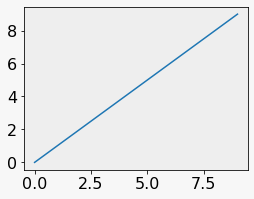

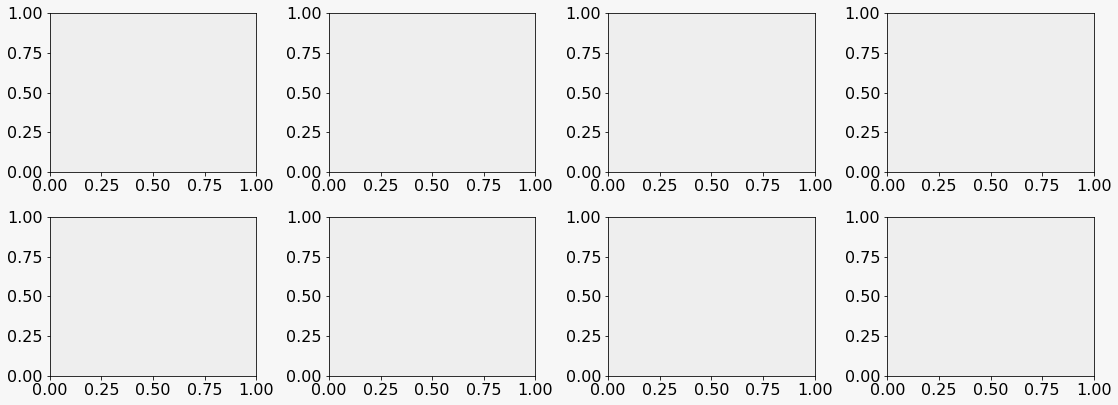

In [49]:
# create fig with size 7X8 (in inches)   and 1inch = 2.54cm
# figsize = [width, height]
fig1 = plt.figure(figsize=[4, 3])

# fig1.patch.set_facecolor('#E0E0E0')
# fig1.patch.set_alpha(0.7)
ax1 = fig1.add_subplot()   # default will same as add_subplot(1, 1, 1)
ax1.plot(range(10))

# or just change to cm by this way
cm = 1/2.54 # inch
fig2 = plt.figure(figsize=[40*cm, 15*cm])
ax2 = fig2.subplots(2, 4)

fig2.tight_layout()   # Otherwise the subplots will overlap

#### Plot errors with reference line

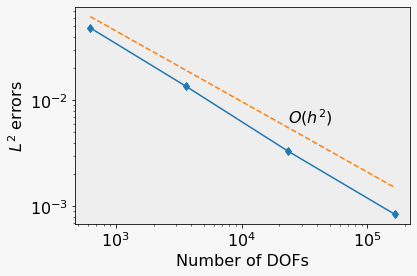

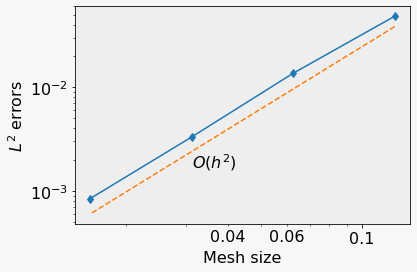

In [54]:
def minor_tick(x, pos):
    if x < 0.1:
        if (np.round(x*100) in [4, 6]):
            return '%.2f' %x
        else:
            return ''
            
    return '%.1f' %x


order = 1

dim = 3
lcs =  [0.125, 0.0625, 0.03125, 0.015625] # Gmsh lcs
ndofs =  [628, 3603, 23472, 164356] # Number of dofs
errors =  [0.04827200204462808, 0.013616633838663416, 0.0033094536713063377, 0.0008433901100836445] # Errors compared with Ref sol
filename = None

p = order + 1
c01 = 2
c02 = -1

x1 = ndofs
x2 = lcs
y = errors

        
c1 = y[-1]/(x1[-1]**(-p/dim)) + c01
c2 = y[-1]/(x2[-1]**p) + c02

y1_ref = [c1*_**(-p/dim) for _ in x1]
y2_ref = [c2*_**p for _ in x2]
fig = plt.figure() # (figsize=[4,3])
ax = fig.add_subplot()
ax.loglog(x1, y, 'd-', x1, y1_ref, '--')
ax.set_xlabel('Number of DOFs')
ax.set_ylabel('$L^2$ errors')
ax.text(x1[-2], y1_ref[-2], '$O(h^%d)$'%p, va='bottom', ha='left')

filename and fig.savefig(filename + '-ndofs.eps', format='eps')

fig = plt.figure() # (figsize=[4,3])
ax = fig.add_subplot()
ax.loglog(x2, y, 'd-', x2, y2_ref, '--')
ax.set_xlabel('Mesh size')
ax.set_ylabel('$L^2$ errors')
ax.text(x2[2], y2_ref[2], '$O(h^%d)$'%p, va='top', ha='left')

ax.xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%.1f'))
ax.xaxis.set_minor_formatter(minor_tick)

filename and fig.savefig(filename + '-maxh.eps', format='eps')

if filename:
    print('filename1: ' + filename + '-ndofs.eps')
    print('filename2: ' + filename + '-maxh.eps')

In [43]:
help(fig.autofmt_xdate)

Help on method autofmt_xdate in module matplotlib.figure:

autofmt_xdate(bottom=0.2, rotation=30, ha='right', which='major') method of matplotlib.figure.Figure instance
    Date ticklabels often overlap, so it is useful to rotate them
    and right align them.  Also, a common use case is a number of
    subplots with shared x-axis where the x-axis is date data.  The
    ticklabels are often long, and it helps to rotate them on the
    bottom subplot and turn them off on other subplots, as well as
    turn off xlabels.
    
    Parameters
    ----------
    bottom : float, default: 0.2
        The bottom of the subplots for `subplots_adjust`.
    rotation : float, default: 30 degrees
        The rotation angle of the xtick labels in degrees.
    ha : {'left', 'center', 'right'}, default: 'right'
        The horizontal alignment of the xticklabels.
    which : {'major', 'minor', 'both'}, default: 'major'
        Selects which ticklabels to rotate.

